# OpenVaccine: mRNA Vaccine Degradation Prediction

<div>
<img src="https://daslab.stanford.edu/site_data/news_img/openvaccine_lores.png" width="300" height="100"/>
</div>

In this competition, you will be predicting the degradation rates at various locations along RNA sequence.

There are multiple ground truth values provided in the training data. While the submission format requires all 5 to be predicted, only the following are scored: `reactivity`, `deg_Mg_pH10`, and `deg_Mg_50C`.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import json
import ast
import seaborn as sns
import os

import lightgbm as lgb
from sklearn.model_selection import train_test_split

from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('ggplot')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Data Exploration
Lets take a look at the data. It's provided in json format.

In [11]:
!ls -GFlash --color ../input/stanford-covid-vaccine/

total 75M
   0 drwxr-xr-x 3 root  116 Sep 24 17:21 ./
   0 drwxr-xr-x 3 root   36 Sep 24 17:21 ../
268K drwxr-xr-x 2 root 192K Sep 24 16:40 bpps/
 16M -rw-r--r-- 1 root  16M Sep 11 00:59 sample_submission.csv
 45M -rw-r--r-- 1 root  45M Sep 24 16:39 stanford-covid-vaccine.zip
1.8M -rw-r--r-- 1 root 1.8M Sep 11 00:59 test.json
 13M -rw-r--r-- 1 root  13M Sep 11 00:59 train.json


The bpps directory has a bunch of numpy data. It's about 670MB in size.

In [13]:
!du -h ../input/stanford-covid-vaccine/bpps/

672M	../input/stanford-covid-vaccine/bpps/


# Loading JSON Files

In [14]:
train = pd.read_json('../input/stanford-covid-vaccine/train.json',lines=True)
test = pd.read_json('../input/stanford-covid-vaccine/test.json', lines=True)
ss = pd.read_csv('../input/stanford-covid-vaccine/sample_submission.csv')
print(f'Train shape: {train.shape}, test shape: {test.shape}, sample submission shape: {ss.shape}')

print('========= train columns ==========')
print([c for c in train.columns])

print('========= test columns ==========')
print([c for c in test.columns])

Train shape: (2400, 19), test shape: (3634, 7), sample submission shape: (457953, 6)
========= train columns ==========
['SN_filter', 'deg_50C', 'deg_Mg_50C', 'deg_Mg_pH10', 'deg_error_50C', 'deg_error_Mg_50C', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_pH10', 'id', 'index', 'predicted_loop_type', 'reactivity', 'reactivity_error', 'seq_length', 'seq_scored', 'sequence', 'signal_to_noise', 'structure']
========= test columns ==========
['id', 'index', 'predicted_loop_type', 'seq_length', 'seq_scored', 'sequence', 'structure']


In [16]:
train.head()

,SN_filter,deg_50C,deg_Mg_50C,deg_Mg_pH10,deg_error_50C,deg_error_Mg_50C,deg_error_Mg_pH10,deg_error_pH10,deg_pH10,id,index,predicted_loop_type,reactivity,reactivity_error,seq_length,seq_scored,sequence,signal_to_noise,structure
0,1,"[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...",id_001f94081,0,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,"[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...",107,68,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,6.894,.....((((((.......)))).)).((.....((..((((((......
1,0,"[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",id_0049f53ba,1,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,"[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...",107,68,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,0.193,.....(((((((((((((((((((((((....)))))))))).)))...
2,1,"[0.9501000000000001, 1.7974999999999999, 1.499...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...",id_006f36f57,2,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,"[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.0931, 0.13290000000000002, 0.11280000000000...",107,68,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,8.800,.....((((.((.....((((.(((.....)))..((((......)...
3,0,"[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[121286.7181, 121286.7182, 121286.7181, 121286...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",id_0082d463b,3,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,"[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...",107,68,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,0.104,......((((((((((((((((......))))))))))))))))((...
4,0,"[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...",id_0087940f4,4,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,"[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...",107,68,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,0.423,.....(((((((.((((((((((((.(((((((((....)))))))...


# Look at Numpy Data

We don't know much about the numpy data from the data description. We think they might be Base Pairing Probability Matrix files. According to [this paper abstract:](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3514005/#:~:text=A%20base%2Dpairing%20probability%20matrix,structure%20prediction%20and%20motif%20search)

*A base-pairing probability matrix (BPPM) stores the probabilities for every possible base pair in an RNA sequence and has been used in many algorithms in RNA informatics (e.g., RNA secondary structure prediction and motif search). In this study, we propose a novel algorithm to perform iterative updates of a given BPPM, satisfying marginal probability constraints that are (approximately) given by recently developed biochemical experiments, such as SHAPE, PAR, and FragSeq. The method is easily implemented and is applicable to common models for RNA secondary structures, such as energy-based or machine-learning–based models. In this article, we focus mainly on the details of the algorithms, although preliminary computational experiments will also be presented.*



In [17]:
bpps_files = os.listdir('../input/stanford-covid-vaccine/bpps/')
example_bpps = np.load(f'../input/stanford-covid-vaccine/bpps/{bpps_files[0]}')
print('bpps file shape:', example_bpps.shape)

bpps file shape: (107, 107)


Lets plot this data for 25 examples.

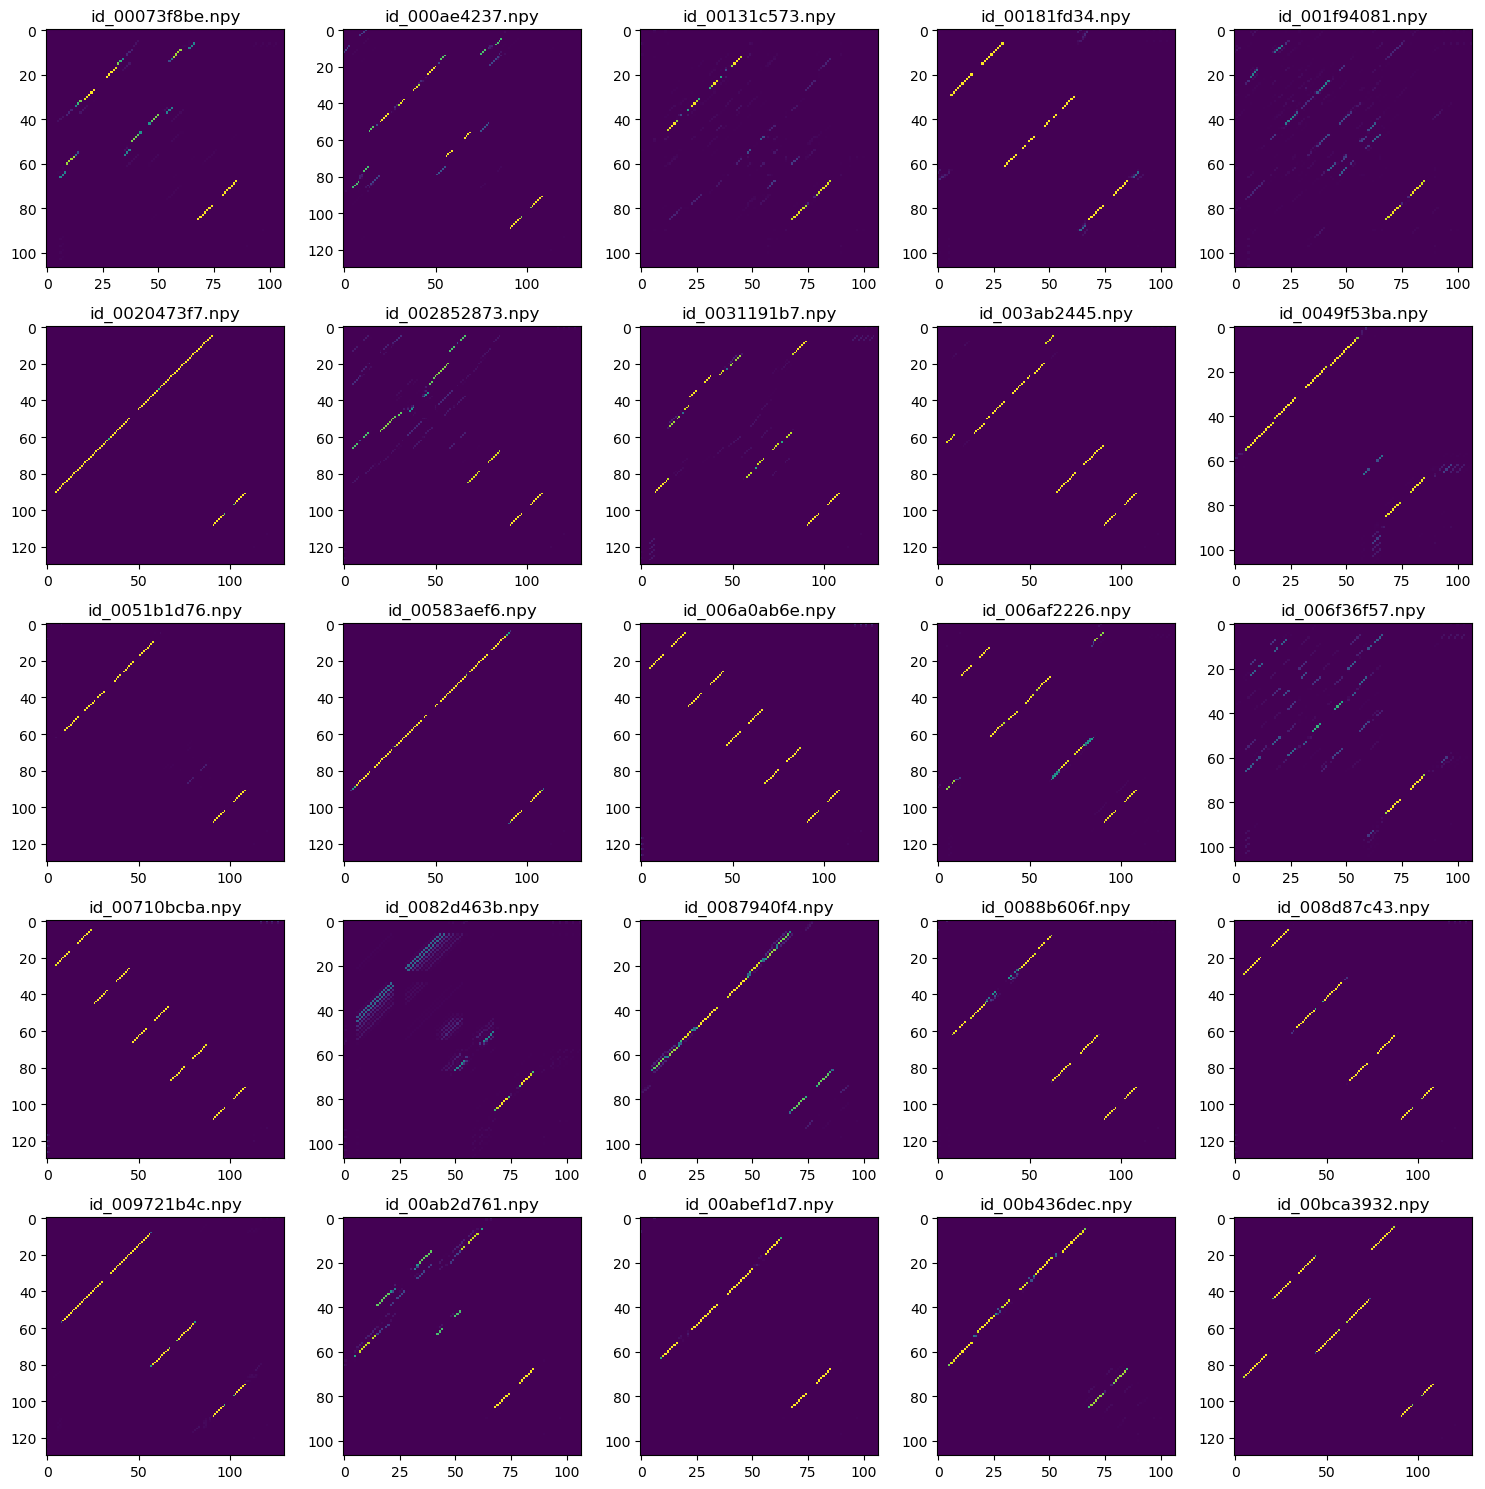

In [18]:
plt.style.use('default')
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
axs = axs.flatten()
for i, f in enumerate(bpps_files):
    if i == 25:
        break
    example_bpps = np.load(f'../input/stanford-covid-vaccine/bpps/{f}')
    axs[i].imshow(example_bpps)
    axs[i].set_title(f)
plt.tight_layout()
plt.show()

# Sample Submission

Lets quickly look at the sample submission format. Even though we submit for addional solumns, only three columns are scored: `reactivity`, `deg_Mg_pH10`, and `deg_Mg_50C`

In [19]:
ss.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


# reactivity column

In the data description we are told:
- `reactivity` - (1x68 vector in train/test, 1x91 in final scoring) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likely secondary structure of the RNA sample.


In [ ]:
train['reactivity'].head()

In [ ]:
print('===== Example Train Reacivity ======')
print([round(r, 2) for r in train['reactivity'][0]])

## deg_Mg_pH10 column

We are told:
- deg_Mg_pH10 - (1x68 vector in train/test, 1x91 in final scoring) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium in high pH (pH 10).

In [ ]:
print('===== Example Train deg_Mg_pH10 value ======')
print([round(r, 2) for r in train['deg_Mg_pH10'][0]])

## deg_Mg_50C column
- deg_Mg_50C - (1x68 vector in train/test, 1x91 in final scoring) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium at high temperature (50 degrees Celsius).


In [ ]:
print('===== Example Train deg_Mg_50C value ======')
print([round(r, 2) for r in train['deg_Mg_50C'][0]])

## signal_to_noise feature

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 3))
ax = sns.distplot(train['signal_to_noise'])
ax.set_title('Signal to Noise feature (train)')
plt.show()

## seq_length

Train data consists of only 107 sequence length. The test data contains mostly 130 sequence lengths.

In [ ]:
test['seq_length'].value_counts() \
    .plot(kind='bar', figsize=(10, 4),
          color=color_pal[4],
         title='Sequence Length in public test set')
plt.show()

# Baseline Submission [0.47840 LB]
## Predict the average value for each target column
Lets first calculate the average value for the target columns. And then create a 91 length vector as a baseline submission.

In [ ]:
fig, axs = plt.subplots(3, 1,
                        figsize=(10, 6),
                        sharex=True)
axs = axs.flatten()
train['mean_reactivity'] = train['reactivity'].apply(lambda x: np.mean(x))
train['mean_deg_Mg_pH10'] = train['deg_Mg_pH10'].apply(lambda x: np.mean(x))
train['mean_deg_Mg_50C'] = train['deg_Mg_50C'].apply(lambda x: np.mean(x))

train['mean_reactivity'] \
    .plot(kind='hist',
          bins=50,
          color=color_pal[0],
          title='Distribution of Mean Reactivity in training set',
         ax=axs[0])
train['mean_deg_Mg_pH10'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[1],
          color=color_pal[4],
          title='Distribution of Mean deg_Mg_pH10 in training set')
train['mean_deg_Mg_50C'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[2],
          color=color_pal[3],
          title='Distribution of Mean deg_Mg_50C in training set')
plt.tight_layout()
plt.show()

## Fill in predictions with the mean value


In [ ]:
mean_react = train['mean_reactivity'].mean()
mean_deg_Mg_pH10 = train['mean_deg_Mg_pH10'].mean()
mean_deg_Mg_50C = train['mean_deg_Mg_50C'].mean()

ss['reactivity'] = mean_react
ss['deg_Mg_pH10'] = mean_deg_Mg_pH10
ss['deg_Mg_50C'] = mean_deg_Mg_50C

ss.to_csv('submission.csv', index=False)
ss.head()

# Plot the Targets for Each Training Example
First we need to split the list of 68 values for each target into their own columns. Then we can plot.

In [ ]:
# Split the 68 Reactivity values each into it's own column
for n in range(68):
    train[f'reactivity_{n}'] = train['reactivity'].apply(lambda x: x[n])
    
REACTIVITY_COLS = [r for r in train.columns if 'reactivity_' in r and 'error' not in r]

ax = train.set_index('id')[REACTIVITY_COLS] \
    .T \
    .plot(color='black',
          alpha=0.01,
          ylim=(-0.5, 5),
          title='reactivity of training set',
          figsize=(15, 5))
ax.get_legend().remove()

In [ ]:
for n in range(68):
    train[f'deg_Mg_pH10_{n}'] = train['deg_Mg_pH10'].apply(lambda x: x[n])
    
DEG_MG_PH10_COLS = [r for r in train.columns if 'deg_Mg_pH10_' in r and 'error' not in r]

ax = train.set_index('id')[DEG_MG_PH10_COLS] \
    .T \
    .plot(color='c',
          alpha=0.01,
          ylim=(-0.5, 5),
          title='Deg Mg Ph10 of training set',
          figsize=(15, 5))
ax.get_legend().remove()

In [ ]:
for n in range(68):
    train[f'deg_Mg_50C_{n}'] = train['deg_Mg_50C'].apply(lambda x: x[n])
    
DEG_MG_50C_COLS = [r for r in train.columns if 'deg_Mg_50C_' in r and 'error' not in r]

ax = train.set_index('id')[DEG_MG_50C_COLS] \
    .T \
    .plot(color='m',
          alpha=0.2,
          ylim=(-2, 7),
          title='Deg Mg 50C of training set',
          figsize=(15, 5)
         )
ax.get_legend().remove()

# Relationship between targets
Colored by `SN_filter` although I'm not clear from the data description what this column represents.


In [ ]:
sns.pairplot(data=train,
             vars=['mean_reactivity',
                   'mean_deg_Mg_pH10',
                    'mean_deg_Mg_50C'],
            hue='SN_filter')
plt.show()

# Simple Baseline Using Simple LightGBM [0.47706 LB]

This model still predicts the same value for each id in the test set, but the predicted value is based off of the sequence data.

In [ ]:
# Expand Sequence Features
for n in range(107):
    train[f'sequence_{n}'] = train['sequence'].apply(lambda x: x[n]).astype('category')
    test[f'sequence_{n}'] = test['sequence'].apply(lambda x: x[n]).astype('category')

SEQUENCE_COLS = [c for c in train.columns if 'sequence_' in c]

for target in ['reactivity','deg_Mg_pH10','deg_Mg_50C']:

    X = train[SEQUENCE_COLS]
    y = train[f'mean_{target}']
    X_test = test[SEQUENCE_COLS]

    X_train, X_val, y_train, y_val = train_test_split(X, y)

    reg = lgb.LGBMRegressor(n_estimators=1000)
    reg.fit(X_train, y_train,
            eval_set=(X_val, y_val),
           early_stopping_rounds=100,
           verbose=100)

    test[f'mean_{target}_pred'] = reg.predict(X_test)

## Map mean predictions to test

In [ ]:
ss['id'] = 'id_' + ss['id_seqpos'].str.split('_', expand=True)[1]

# Merge my predicted average values
ss_new = ss. \
    drop(['reactivity','deg_Mg_pH10','deg_Mg_50C'], axis=1) \
    .merge(test[['id',
               'mean_reactivity_pred',
               'mean_deg_Mg_pH10_pred',
               'mean_deg_Mg_50C_pred']] \
               .rename(columns={'mean_reactivity_pred' : 'reactivity',
                                'mean_deg_Mg_pH10_pred': 'deg_Mg_pH10',
                                'mean_deg_Mg_50C_pred' : 'deg_Mg_50C'}
                      ),
         on='id',
        validate='m:1')

In [ ]:
TARGETS = ['reactivity','deg_Mg_pH10','deg_Mg_50C']
for i, t in enumerate(TARGETS):
    ss_new[t].plot(kind='hist',
                              figsize=(10, 3),
                              bins=100,
                              color=color_pal[i*3],
                              title=f'Submission {t}')
    plt.show()

In [ ]:
ss_new.sample(10)

In [ ]:
# Make Submission
ss = pd.read_csv('../input/stanford-covid-vaccine/sample_submission.csv')
ss_new[ss.columns].to_csv('submission_lgbm_v1.csv', index=False)

# Improve Baseline by adding: **structure** and **predicted_loop_type** features [0.47520 LB]

In [ ]:
# Expand Sequence Features
for n in range(107):
    train[f'structure_{n}'] = train['structure'].apply(lambda x: x[n]).astype('category')
    test[f'structure_{n}'] = test['structure'].apply(lambda x: x[n]).astype('category')
    train[f'predicted_loop_type_{n}'] = train['predicted_loop_type'].apply(lambda x: x[n]).astype('category')
    test[f'predicted_loop_type_{n}'] = test['predicted_loop_type'].apply(lambda x: x[n]).astype('category')
    train[f'sequence_{n}'] = train['sequence'].apply(lambda x: x[n]).astype('category')
    test[f'sequence_{n}'] = test['sequence'].apply(lambda x: x[n]).astype('category')

SEQUENCE_COLS = [c for c in train.columns if 'sequence_' in c]
STRUCTURE_COLS = [c for c in train.columns if 'structure_' in c]
PLT_COLS = [c for c in train.columns if 'predicted_loop_type_' in c]

for target in ['reactivity','deg_Mg_pH10','deg_Mg_50C']:

    X = train[SEQUENCE_COLS + STRUCTURE_COLS + PLT_COLS]
    y = train[f'mean_{target}']
    X_test = test[SEQUENCE_COLS + STRUCTURE_COLS + PLT_COLS]

    X_train, X_val, y_train, y_val = train_test_split(X, y)

    reg = lgb.LGBMRegressor(n_estimators=10000,
                            learning_rate=0.001,
                            feature_fraction=0.8)
    reg.fit(X_train, y_train,
            eval_set=(X_val, y_val),
           early_stopping_rounds=100,
           verbose=1000)

    test[f'mean_{target}_pred'] = reg.predict(X_test)
    
ss['id'] = 'id_' + ss['id_seqpos'].str.split('_', expand=True)[1]

# Merge my predicted average values
ss_new = ss. \
    drop(['reactivity','deg_Mg_pH10','deg_Mg_50C'], axis=1) \
    .merge(test[['id',
               'mean_reactivity_pred',
               'mean_deg_Mg_pH10_pred',
               'mean_deg_Mg_50C_pred']] \
               .rename(columns={'mean_reactivity_pred' : 'reactivity',
                                'mean_deg_Mg_pH10_pred': 'deg_Mg_pH10',
                                'mean_deg_Mg_50C_pred' : 'deg_Mg_50C'}
                      ),
         on='id',
        validate='m:1')

ss = pd.read_csv('../input/stanford-covid-vaccine/sample_submission.csv')
ss_new[ss.columns].to_csv('submission.csv', index=False)

TARGETS = ['reactivity','deg_Mg_pH10','deg_Mg_50C']
for i, t in enumerate(TARGETS):
    ss_new[t].plot(kind='hist',
                              figsize=(10, 3),
                              bins=100,
                              color=color_pal[i*3],
                              title=f'Submission {t}')
    plt.show()

# Modeling approach. Fit Line for Reactivity?
Lets test and see what a regression line looks like for some example samples. Since we are only given 68 values in the training set and will predict 93 in the test, this might be a good idea for extending the trend beyond 93. 

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(12, 10))
axs = axs.flatten()
i = 0
for row in train.sample(25, random_state=42).iterrows():
    myid = row[1]['id']
    reactivity_array = row[1][REACTIVITY_COLS].values
    sns.regplot(np.array(range(68)).reshape(-1, 1),
                reactivity_array,
                ax=axs[i],
                color=next(color_cycle))
    axs[i].set_title(myid)
    i += 1
fig.suptitle('Reactivity Array for 25 Train Examples with Regression Line',
             fontsize=18,
             y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(5, 5,
                        figsize=(12, 10),
                       sharex=True)
axs = axs.flatten()
i = 0
for row in train.sample(25, random_state=42).iterrows():
    myid = row[1]['id']
    reactivity_array = row[1][DEG_MG_50C_COLS].values
    sns.regplot(np.array(range(68)).reshape(-1, 1),
                reactivity_array,
                ax=axs[i],
                color=next(color_cycle))
    axs[i].set_title(myid)
    i += 1
fig.suptitle('"DEG_MG_50C" Array for 25 Train Examples with Regression Line',
             fontsize=18,
             y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(12, 10))
axs = axs.flatten()
i = 0
for row in train.sample(25, random_state=42).iterrows():
    myid = row[1]['id']
    reactivity_array = row[1][DEG_MG_PH10_COLS].values
    sns.regplot(np.array(range(68)).reshape(-1, 1),
                reactivity_array,
                ax=axs[i],
                color=next(color_cycle))
    axs[i].set_title(myid)
    i += 1
fig.suptitle('"DEG_MG_PH10" Array for 25 Train Examples with Regression Line',
             fontsize=18,
             y=1.02)
plt.tight_layout()
plt.show()

# Better LightGBM Model
- Expanding for one row per prediction

In [ ]:
import pandas as pd
import numpy as np
import json
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pylab as plt

def expand_columns(df):
    df = df.copy()
    df = df.drop('index', axis=1)
    max_seq_length = df['seq_length'].max()
    SEQUENCE_COLS = []; STRUCTURE_COLS = []; PRED_LOOP_TYPE_COLS = []
    for s in range(130):
        df[f'sequence_{s}'] = df['sequence'].str[s]
        df[f'structure_{s}'] = df['structure'].str[s]
        df[f'predicted_loop_type_{s}'] = df['predicted_loop_type'].str[s]
        SEQUENCE_COLS.append(f'sequence_{s}')
        STRUCTURE_COLS.append(f'structure_{s}')
    return df, SEQUENCE_COLS, STRUCTURE_COLS

def parse_sample_submission(ss):
    ss = ss.copy()
    ss['id'] = ss['id_seqpos'].str.split('_', expand=True)[1]
    ss['seqpos'] = ss['id_seqpos'].str.split('_', expand=True)[2].astype('int')
    return ss

In [ ]:
def get_train_long(train):
    dfs = []

    def pad(feat, tolen):
        padded = np.pad(feat,
                        (0, tolen-len(feat)),
                        mode='constant',
                        constant_values=np.nan)
        return padded

    for d in tqdm(train.itertuples(), total=len(train)):
        sequence = [s for s in d[3]]
        seq_len = len(sequence)
        structure = [s for s in d[4]]
        predicted_loop_type = [s for s in d[5]]
        reactivity_error = pad([s for s in d[10]], seq_len)
        deg_error_Mg_pH10 = pad([s for s in d[11]], seq_len)
        deg_error_pH10 = pad([s for s in d[12]], seq_len)
        deg_error_Mg_50C = pad([s for s in d[13]], seq_len)
        deg_error_50C = pad([s for s in d[14]], seq_len)

        reactivity = pad([s for s in d[15]], seq_len)
        deg_Mg_pH10 = pad([s for s in d[16]], seq_len)
        deg_pH10 = pad([s for s in d[17]], seq_len)
        deg_Mg_50C = pad([s for s in d[18]], seq_len)
        deg_50C = pad([s for s in d[10]], seq_len)
        myid = [d[2]] * len(sequence)
        seqpos = [c for c in range(len(sequence))]
        dfs.append(pd.DataFrame(np.array([myid,
                                          seqpos,
                                          sequence,
                                          structure,
                                          predicted_loop_type,
                                          reactivity_error,
                                          deg_error_Mg_pH10,
                                          deg_error_pH10,
                                          deg_error_Mg_50C,
                                          deg_error_50C,
                                          reactivity,
                                          deg_Mg_pH10,
                                          deg_pH10,
                                          deg_Mg_50C,
                                         ]).T))
    train_long = pd.concat(dfs)

    train_long.columns=['id',
               'seqpos',
               'sequence',
               'structure',
               'predicted_loop_type',
               'reactivity_error',
               'deg_error_Mg_pH10',
               'deg_error_pH10',
               'deg_error_Mg_50C',
               'deg_error_50C',
               'reactivity',
               'deg_Mg_pH10',
               'deg_pH10',
               'deg_Mg_50C']

    return train_long


def get_test_long(test):
    dfs = []

    def pad(feat, tolen):
        padded = np.pad(feat,
                        (0, tolen-len(feat)),
                        mode='constant',
                        constant_values=np.nan)
        return padded

    for d in tqdm(test.itertuples(), total=len(test)):
        sequence = [s for s in d[3]]
        seq_len = len(sequence)
        structure = [s for s in d[4]]
        predicted_loop_type = [s for s in d[5]]
        myid = [d[2]] * len(sequence)
        seqpos = [c for c in range(len(sequence))]
        dfs.append(pd.DataFrame(np.array([myid,
                                          seqpos,
                                          sequence,
                                          structure,
                                          predicted_loop_type,
                                         ]).T))
    test_long = pd.concat(dfs)

    test_long.columns=['id',
               'seqpos',
               'sequence',
               'structure',
               'predicted_loop_type']

    return test_long

def add_long_features(df):
    df = df.copy()
    df['seqpos'] = df['seqpos'].astype('int')
    df = df.merge(df.query('seqpos <= 106') \
                    .groupby('id')['sequence'] \
                      .value_counts() \
                      .unstack() \
                      .reset_index(),
             how='left',
             on=['id'],
             validate='m:1'
            )
    
    df = df.merge(df.query('seqpos <= 106') \
                  .groupby('id')['structure'] \
                      .value_counts() \
                      .unstack() \
                      .reset_index(),
             how='left',
             on=['id'],
             validate='m:1'
            )

    df = df.merge(df.query('seqpos <= 106') \
                  .groupby('id')['predicted_loop_type'] \
                      .value_counts() \
                      .unstack() \
                      .reset_index(),
             how='left',
             on=['id'],
             validate='m:1'
            )
    for shift in [-5, -4, -3, -2 -1, 1, 2, 3, 4, 5]:
        for f in ['sequence','structure','predicted_loop_type']:
            df[f'{f}_shift{shift}'] = df.groupby('id')[f].shift(shift)
    return df

In [ ]:
def make_feature_types(df, features):
    df = df.copy()
    df = df.replace('nan', np.nan)
    for f in features:
        try:
            df[f] = pd.to_numeric(df[f])
        except ValueError:
            df[f] = df[f].astype('category')
    return df

In [ ]:
train = pd.read_json('../input/stanford-covid-vaccine/train.json', lines=True)
test = pd.read_json('../input/stanford-covid-vaccine/test.json', lines=True)
ss = pd.read_csv('../input/stanford-covid-vaccine/sample_submission.csv')

train_expanded, SEQUENCE_COLS, STRUCTURE_COLS = expand_columns(train)
test_expanded, SEQUENCE_COLS, STRUCTURE_COLS = expand_columns(test)
ss = parse_sample_submission(ss)

train_long = get_train_long(train)
test_long = get_test_long(test)

train_long = add_long_features(train_long)
test_long = add_long_features(test_long)

FEATURES = ['seqpos',
            'sequence',
            'structure',
            'predicted_loop_type',
            'A', 'C', 'G', 'U', '(', ')', '.', 'B', 'E',
            'H', 'I', 'M', 'S', 'X',
            'sequence_shift-5', 'structure_shift-5',
            'predicted_loop_type_shift-5', 'sequence_shift-4', 'structure_shift-4',
            'predicted_loop_type_shift-4', 'sequence_shift-3', 'structure_shift-3',
            'predicted_loop_type_shift-3', 'sequence_shift1', 'structure_shift1',
            'predicted_loop_type_shift1', 'sequence_shift2', 'structure_shift2',
            'predicted_loop_type_shift2', 'sequence_shift3', 'structure_shift3',
            'predicted_loop_type_shift3', 'sequence_shift4', 'structure_shift4',
            'predicted_loop_type_shift4', 'sequence_shift5', 'structure_shift5',
            'predicted_loop_type_shift5']

train_long = make_feature_types(train_long, FEATURES)
test_long = make_feature_types(test_long, FEATURES)

train_ids, val_ids = train_test_split(train['id'].unique())

TARGETS = ['reactivity','deg_Mg_pH10','deg_Mg_50C']
fis = []
for t in TARGETS:
    print(f'==== Running for target {t} ====')
    X_train = train_long.dropna(subset=[t]).loc[train_long['id'].isin(train_ids)][FEATURES].copy()
    y_train = train_long.dropna(subset=[t]).loc[train_long['id'].isin(train_ids)][t].copy()
    X_val = train_long.dropna(subset=[t]).loc[train_long['id'].isin(val_ids)][FEATURES].copy()
    y_val = train_long.dropna(subset=[t]).loc[train_long['id'].isin(val_ids)][t].copy()
    X_test = test_long[FEATURES].copy()
    y_train = pd.to_numeric(y_train)
    y_val = pd.to_numeric(y_val)
    
    reg = lgb.LGBMRegressor(n_estimators=10000,
                            learning_rate=0.01,
                            importance_type='gain')
    reg.fit(X_train, y_train,
            eval_set=(X_val, y_val),
           verbose=1000,
           early_stopping_rounds=500)

    fi_df = pd.DataFrame(index=FEATURES, 
                 data=reg.feature_importances_,
                 columns=[f'importance_{t}'])
    
    fi_df.sort_values(f'importance_{t}') \
        .plot(kind='barh', figsize=(8, 15), title=t)
    plt.show()
    fis.append(fi_df)
    
    test_long[f'{t}_pred'] = reg.predict(X_test)

## Create Submission

In [ ]:
test_long['id_seqpos'] = test_long['id'] + '_' + test_long['seqpos'].astype('str')

test_long['deg_pH10'] = 0
test_long['deg_50C'] = 0
test_long = test_long.rename(columns={'reactivity_pred':'reactivity',
                          'deg_Mg_pH10_pred': 'deg_Mg_pH10',
                          'deg_Mg_50C_pred': 'deg_Mg_50C'})

ss = pd.read_csv('../input/stanford-covid-vaccine/sample_submission.csv')
assert test_long[ss.columns].shape == ss.shape

test_long[ss.columns].to_csv('submission.csv', index=False)

## Plot Distribution of predictions vs. Training

In [ ]:
for t in TARGETS:
    train_long[t].dropna().astype('float').plot(kind='hist', bins=50, figsize=(10, 3), title=t)
    test_long[t].plot(kind='hist', bins=50, figsize=(10, 3), title=t)
    plt.show()